# Setup

In [10]:
import pandas as pd
import seaborn as sns
import os
import linecache

from src.profiling import load_pkl
from src.viz import plot_grouped_barchart, convert_shortened_bytes_to_int, bytes_to_readable_fmt
import tracemalloc
import warnings
import yappi
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Analyze Overall Results

In [4]:
files_to_load = ['profiling16']

results = []
for file in files_to_load:
    results += load_pkl(f"{os.getcwd()}/profiles/{file}.pkl")

df = pd.DataFrame.from_records(results)

df['total_runtime_minutes'] = df['total_runtime_seconds'] / 60

# parse docker output into bytes
for col in ['postgis/postgis_disk_space', 'redis_disk_space']:
    split_df = df.loc[:, col].str.split('(', expand=True)
    split_df[1] = split_df[1].replace(to_replace='\)', value="", regex=True).replace(to_replace='virtual ', value="", regex=True)
    split_df = split_df.applymap(convert_shortened_bytes_to_int)
    split_df.columns = [f'{col}_used', f'{col}_virtual']
    split_df[f'{col}_total'] = split_df.sum(axis=1)
    df = pd.concat([df, split_df], axis=1)

for col in ['postgis/postgis_cpu_util', 'redis_cpu_util', 'postgis/postgis_mem_util', 'redis_mem_util']:
    df[col] = df[col].str.rstrip('%').astype('float') / 100.0


# combine tracemalloc columns
df['client_tracemalloc_top10'] = df[[i for i in range(10)]].apply(dict, axis=1)
df.drop([i for i in range(10)], axis=1, inplace=True)
df.columns

Index(['client', 'dataset_name', 'n_images', 'n_annotations', 'n_labels',
       'start', 'total_runtime_seconds', 'exception',
       'postgis/postgis_disk_space', 'postgis/postgis_cpu_util',
       'postgis/postgis_mem_util', 'redis_disk_space', 'redis_cpu_util',
       'redis_mem_util', 'total_runtime_minutes',
       'postgis/postgis_disk_space_used', 'postgis/postgis_disk_space_virtual',
       'postgis/postgis_disk_space_total', 'redis_disk_space_used',
       'redis_disk_space_virtual', 'redis_disk_space_total',
       'client_tracemalloc_top10'],
      dtype='object')

In [5]:
df.head(5)

,client,dataset_name,n_images,n_annotations,n_labels,start,total_runtime_seconds,exception,postgis/postgis_disk_space,postgis/postgis_cpu_util,...,redis_cpu_util,redis_mem_util,total_runtime_minutes,postgis/postgis_disk_space_used,postgis/postgis_disk_space_virtual,postgis/postgis_disk_space_total,redis_disk_space_used,redis_disk_space_virtual,redis_disk_space_total,client_tracemalloc_top10
0,<velour.client.Client object at 0x147886a90>,profiling16,2,2,2,168336.837575,1.78,,63B (virtual 593MB),0.0001,...,0.0024,0.0018,0.029667,63,621805568,621805631,0,191889408,191889408,{0: {'filename': '/Users/nthorlind/git/sw/velo...


## Total Runtime

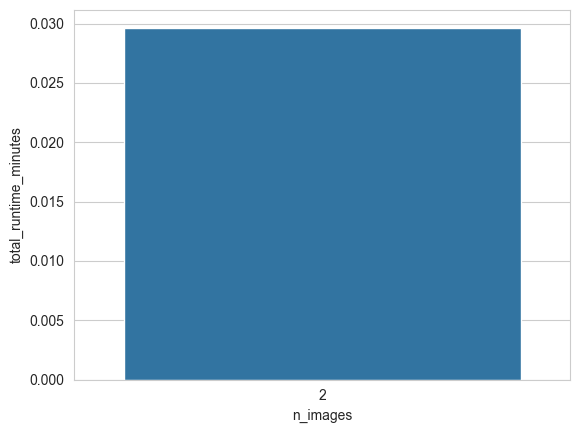

In [6]:
plot_grouped_barchart(df=df, x="n_images", y="total_runtime_minutes", hue=None)


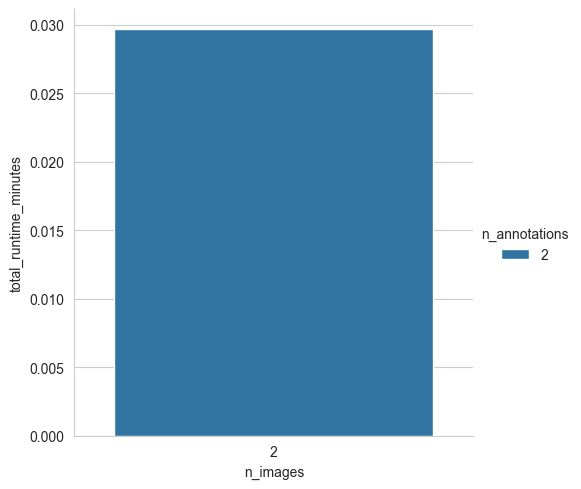

In [7]:
plot_grouped_barchart(df=df, x="n_images", y="total_runtime_minutes", hue='n_annotations')


## Docker Stats

In [8]:
df

,client,dataset_name,n_images,n_annotations,n_labels,start,total_runtime_seconds,exception,postgis/postgis_disk_space,postgis/postgis_cpu_util,...,redis_cpu_util,redis_mem_util,total_runtime_minutes,postgis/postgis_disk_space_used,postgis/postgis_disk_space_virtual,postgis/postgis_disk_space_total,redis_disk_space_used,redis_disk_space_virtual,redis_disk_space_total,client_tracemalloc_top10
0,<velour.client.Client object at 0x147886a90>,profiling16,2,2,2,168336.837575,1.78,,63B (virtual 593MB),0.0001,...,0.0024,0.0018,0.029667,63,621805568,621805631,0,191889408,191889408,{0: {'filename': '/Users/nthorlind/git/sw/velo...


### postgis

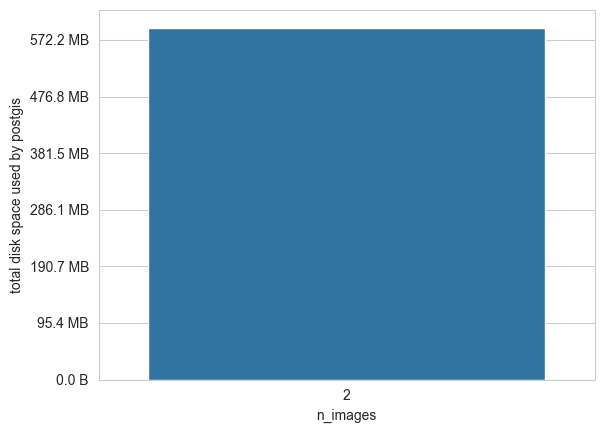

In [9]:
plot_grouped_barchart(df=df, x="n_images", y="postgis/postgis_disk_space_total", hue=None, y_axis_label='total disk space used by postgis', convert_bytes=True)


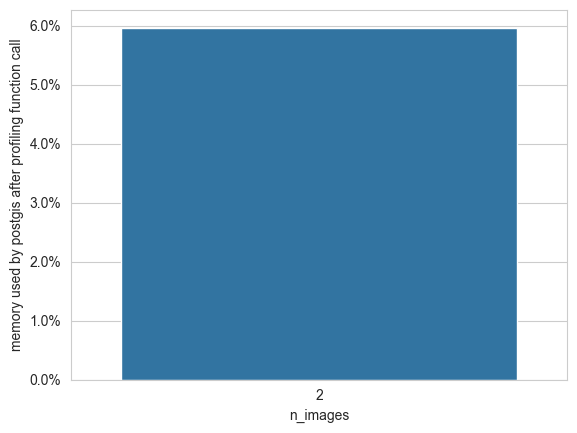

In [10]:
# NOTE: mem_util is the memory usage at the time the snapshot was taken, not the overall peak memory usage
plot_grouped_barchart(df=df, x="n_images", y="postgis/postgis_mem_util", hue=None, y_axis_label='memory used by postgis after profiling function call', convert_perc=True)

### redis

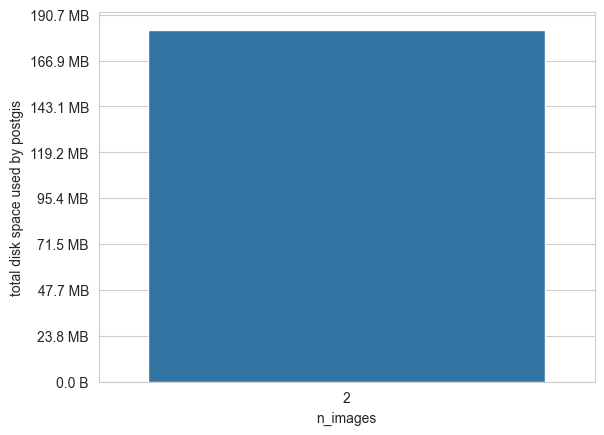

In [11]:
plot_grouped_barchart(df=df, x="n_images", y="redis_disk_space_total", hue=None, y_axis_label='total disk space used by postgis', convert_bytes=True)


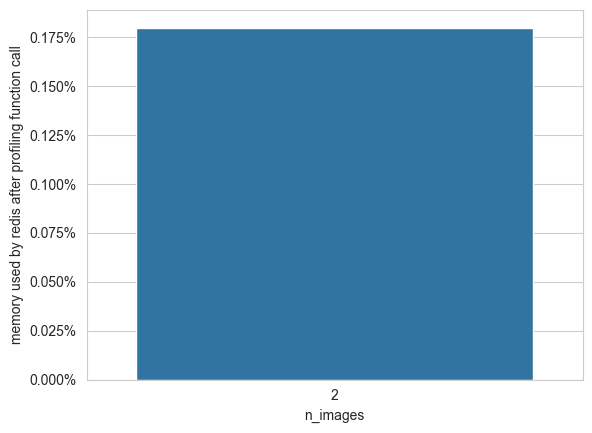

In [12]:
# NOTE: mem_util is the memory usage at the time the snapshot was taken, not the overall peak memory usage
plot_grouped_barchart(df=df, x="n_images", y="redis_mem_util", hue=None, y_axis_label='memory used by redis after profiling function call', convert_perc=True)

# Analyze Backend Profiles

## cprofile

Use this command to analyze CProfile reports in snakeviz:

```
snakeviz utils/profiles/create_groundtruths.cprofile
```

## tracemalloc

### create_groundtruth

In [3]:
def _print_tracemalloc_peaks(dct:dict):
    size_pct = (dct["second_size"]-dct["first_size"])/dct["first_size"]
    print(f'Original size: {bytes_to_readable_fmt(dct["first_size"], 0)}')
    print(f'Final size: {bytes_to_readable_fmt(dct["second_size"], 0)}')
    print(f'Percent Change: {size_pct:2%}')
    print('')

tracemalloc_path = 'profiles/create_groundtruths.tracemalloc'
snapshot = tracemalloc.Snapshot.load(tracemalloc_path)
tracemalloc_dct = load_pkl(tracemalloc_path + '.pkl')


_print_tracemalloc_peaks(tracemalloc_dct)

Original size: 968.7 KB
Final size: 1.1 MB
Percent Change: 16.687232%



In [7]:

def _display_top_tracemalloc(snapshot:tracemalloc.Snapshot, key_type:str='lineno', limit:int=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
        tracemalloc.Filter(True, '*/velour/*')
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    loc: %s:%s' % (frame.filename, frame.lineno))
            print('    func: %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

_display_top_tracemalloc(snapshot=snapshot)

Top 10 lines
#1: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:69: 1.0 KiB
    loc: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:69
    func: with open(
#2: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/annotation.py:25: 0.9 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/annotation.py:25
    func: def create_annotation(
#3: /Users/nthorlind/git/sw/velour/api/velour_api/backend/stateflow.py:97: 0.9 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/stateflow.py:97
    func: def wrapper(*args, **kwargs):
#4: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/metadata.py:14: 0.8 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/metadata.py:14
    func: def create_metadatum(
#5: /Users/nthorlind/git/sw/velour/api/velour_api/schemas/stateflow.py:160: 0.6 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/schemas/stateflow.py:160
    func: def set_dataset_status(self, dataset_name: st

## yappi

NOTE: This profiler is difficult to visualize without kCacheGrind. Prefer cprofile for now.

In [11]:
stats = yappi.get_func_stats()
stats.add("profiles/create_groundtruths.yappi")

stats.sort("tsub", "desc").print_all()


Clock type: WALL
Ordered by: tsub, desc

name                                  ncall  tsub      ttot      tavg      
..hon3.11/asyncio/tasks.py:627 sleep  4      0.212044  0.212353  0.053088
..y:311 _set_result_unless_cancelled  4      0.000127  0.000225  0.000056
..icorn/server.py:235 Server.on_tick  4      0.000046  0.000046  0.000012
..ils/src/profiling.py:185 wrap_func  2/1    0.000013  0.423179  0.211589
../uvicorn/server.py:63 Server.serve  1      0.000000  0.000000  0.000000
..orn/server.py:226 Server.main_loop  1      0.000000  0.000000  0.000000
